In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV,train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,auc
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
path_out = r'C:\Users\karl\Documents\datasets'
df_churn = pd.read_csv(r'C:\Users\karl\Documents\datasets\Churn_Modelling.csv',sep=",")

In [61]:
def encode_ohe(df,numeric_cols,categorical_cols):
    """
    fonction qui permet d encoder les variables categorielles et de standardiser les variables numerique
    a travers un pipeline.    
    
    Parameters
    ----------
    df : TYPE dataframe
    numeric_cols : liste
        liste de nom de colonne de type numerique
    categorical_cols : liste
        liste de nom de colonne de type categorielle

    Returns
    -------
    ohe_encode_df : dataframe
        dataframe valeurs numeriques standardisees et colonnes categorielles encodees a chaud
        
    """
    numeric_transformer = Pipeline(steps=[
        ('imputer',SimpleImputer(strategy='constant',fill_value=0)),
        ('scaler',StandardScaler())
        ])
    
    categ_transformer = Pipeline(steps=[
        ('imputer',SimpleImputer(strategy='constant',fill_value='inconnue')),
        ('ohe',OneHotEncoder(handle_unknown='ignore'))
        ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num',numeric_transformer,numeric_cols),
            ('cat',categ_transformer,categorical_cols)
        ])
    
    preprocessor.fit(df)  # fit the ColumnTransformer object on the input data
    
    ohe_columns = list(preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_cols))
    new_columns = numeric_cols + ohe_columns
    ohe_encode_df = pd.DataFrame(preprocessor.transform(df), columns=new_columns)
    return ohe_encode_df 
def split_data(df,y_col):
    from sklearn.model_selection import train_test_split
    x_train,x_test,y_train,y_test = train_test_split(df.loc[:, ~df.columns.isin(y_col)],df[y_col],test_size=0.2,random_state=0)
    return x_train,x_test,y_train,y_test
def plot_roc_curves(models, X_train, y_train, X_test, y_test):
    
    #dans le cas ou on veut reentrainer les modeles pour la comparaison
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbes ROC pour plusieurs modèles')

    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='Modèle %d (AUC = %0.2f)' % (i+1, roc_auc))

    plt.legend(loc="lower right")
    plt.show()
    
def one_stat_result(model, x_train, y_train, x_test, y_test,b_seuil_label=False):
    train_predictions = model.predict(x_train.to_numpy())
    test_predictions = model.predict(x_test.to_numpy())
    if b_seuil_label==True:
        train_predictions = (train_predictions>=0.5).astype(int)
        test_predictions = (test_predictions>=0.5).astype(int)
    print("test_predictions:")
    print(test_predictions)
    # Calculer l'erreur de validation
    validation_error = np.mean(np.abs(train_predictions - y_train.values))
    print("Calculer l'erreur de validation:")
    print(validation_error)
    # Calculer l'erreur de test
    test_error = np.mean(np.abs(test_predictions - y_test.values))
    print("Calculer l'erreur de test:")
    print(test_error)
    # Calculer le rapport entre l'erreur de validation et l'erreur de test
    overfitting_ratio = validation_error / test_error
    print(" overfitting_ratio = validation_error / test_error")
    print(overfitting_ratio)
    cm = confusion_matrix(y_test, test_predictions)
    print(cm)
    cm_matrix = pd.DataFrame(data=cm, columns=['Vrai Positive:1', 'Vraie Negative:0'], 
                             index=['Estimation Positive:1', 'Estimation Negative:0'])

    print(">> resultat de la classification:")
    print(classification_report(y_test, test_predictions))
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
    print('Justesse de la Classification (accuracy) : {0:0.4f}'.format(classification_accuracy))
    classification_error = (FP + FN) / float(TP + TN + FP + FN)
    print('Erreurs de Classification : {0:0.4f}'.format(classification_error))
    recall = TP / float(TP + FN)
    print('Recall ou Sensitivity : {0:0.4f}'.format(recall))
    print("taux de faux positive:")
    false_positive_rate = FP / float(FP + TN)
    print(false_positive_rate)
    print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))
    specificity = TN / (TN + FP)
    print('Specificity : {0:0.4f}'.format(specificity))

In [4]:
X = df_churn.iloc[:,3:13]
y =  df_churn.iloc[:,13]
print(X.dtypes)
l_cat_col = ["Geography","Gender"]
l_num_col = ["CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary"]
print(X.shape)
print(round(X[l_num_col].describe(),2))
df_new = encode_ohe(X, l_num_col, l_cat_col)
df_new["Exited"] = y
print(df_new)
x_train,x_test,y_train,y_test = split_data(df_new,["Exited"])
print(x_train)
print(x_train.shape)

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object
(10000, 10)
       CreditScore       Age    Tenure    Balance  NumOfProducts  HasCrCard  \
count     10000.00  10000.00  10000.00   10000.00       10000.00   10000.00   
mean        650.53     38.92      5.01   76485.89           1.53       0.71   
std          96.65     10.49      2.89   62397.41           0.58       0.46   
min         350.00     18.00      0.00       0.00           1.00       0.00   
25%         584.00     32.00      3.00       0.00           1.00       0.00   
50%         652.00     37.00      5.00   97198.54           1.00       1.00   
75%         718.00     44.00      7.00  127644.24           2.00       1.00   
max         850.00     92.00     10.00  250898.09           4.00       1

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

# Calculer les poids de classe
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train.values.ravel())
class_weights

array([0.6281407 , 2.45098039])

In [48]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dense
from keras.models import Sequential
import os
xtrain,xvalid,ytrain,yvalid = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
classifier = Sequential()
classifier.add(Dense(units=6,kernel_initializer="glorot_uniform",activation='relu',input_dim=x_train.shape[1]))
classifier.add(Dense(units=6,kernel_initializer="glorot_uniform",activation='relu'))
classifier.add(Dense(units=1,kernel_initializer="glorot_uniform",activation='sigmoid'))
classifier.compile(optimizer="adam",loss = 'binary_crossentropy',metrics=["accuracy"])
callback_a = ModelCheckpoint(filepath=os.path.join(path_out,'best_rna_model_churn.hdf5'),monitor='binary_crossentropy',save_best_only=True,save_weights_only=True)
callback_b = EarlyStopping(monitor='binary_crossentropy',mode='min',patience=20,verbose=1)

In [49]:
historique = classifier.fit(xtrain,ytrain,validation_data=(xvalid,yvalid),epochs=300,batch_size=10,callbacks=[callback_a,callback_b])


Epoch 1/300
640/640 [==============================] - 2s 2ms/step - loss: 0.4877 - accuracy: 0.7975 - val_loss: 0.4518 - val_accuracy: 0.7900
Epoch 2/300
640/640 [==============================] - 1s 2ms/step - loss: 0.4358 - accuracy: 0.8020 - val_loss: 0.4409 - val_accuracy: 0.7906
Epoch 3/300
640/640 [==============================] - 2s 3ms/step - loss: 0.4249 - accuracy: 0.8059 - val_loss: 0.4321 - val_accuracy: 0.7944
Epoch 4/300
640/640 [==============================] - 2s 3ms/step - loss: 0.4174 - accuracy: 0.8095 - val_loss: 0.4272 - val_accuracy: 0.8031
Epoch 5/300
640/640 [==============================] - 1s 2ms/step - loss: 0.4109 - accuracy: 0.8164 - val_loss: 0.4187 - val_accuracy: 0.8194
Epoch 6/300
640/640 [==============================] - 1s 2ms/step - loss: 0.4045 - accuracy: 0.8286 - val_loss: 0.4127 - val_accuracy: 0.8306
Epoch 7/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3979 - accuracy: 0.8313 - val_loss: 0.4087 - val_accuracy: 0.8331

640/640 [==============================] - 1s 2ms/step - loss: 0.3584 - accuracy: 0.8487 - val_loss: 0.3615 - val_accuracy: 0.8587
Epoch 19/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3568 - accuracy: 0.8509 - val_loss: 0.3601 - val_accuracy: 0.8594
Epoch 20/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3559 - accuracy: 0.8505 - val_loss: 0.3572 - val_accuracy: 0.8619
Epoch 21/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3549 - accuracy: 0.8525 - val_loss: 0.3588 - val_accuracy: 0.8594
Epoch 22/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3532 - accuracy: 0.8505 - val_loss: 0.3553 - val_accuracy: 0.8606
Epoch 23/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3521 - accuracy: 0.8525 - val_loss: 0.3599 - val_accuracy: 0.8587
Epoch 24/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3516 - accuracy: 0.8539 - val_loss: 0.3548 - val_accuracy: 0.8619
Epoch

640/640 [==============================] - 1s 2ms/step - loss: 0.3438 - accuracy: 0.8573 - val_loss: 0.3466 - val_accuracy: 0.8637
Epoch 36/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3434 - accuracy: 0.8600 - val_loss: 0.3475 - val_accuracy: 0.8631
Epoch 37/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3432 - accuracy: 0.8594 - val_loss: 0.3483 - val_accuracy: 0.8637
Epoch 38/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3426 - accuracy: 0.8564 - val_loss: 0.3471 - val_accuracy: 0.8644
Epoch 39/300
640/640 [==============================] - 2s 2ms/step - loss: 0.3424 - accuracy: 0.8584 - val_loss: 0.3466 - val_accuracy: 0.8587
Epoch 40/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3415 - accuracy: 0.8570 - val_loss: 0.3465 - val_accuracy: 0.8637
Epoch 41/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3406 - accuracy: 0.8606 - val_loss: 0.3484 - val_accuracy: 0.8600
Epoch

640/640 [==============================] - 2s 2ms/step - loss: 0.3355 - accuracy: 0.8606 - val_loss: 0.3473 - val_accuracy: 0.8612
Epoch 53/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3377 - accuracy: 0.8603 - val_loss: 0.3443 - val_accuracy: 0.8662
Epoch 54/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3364 - accuracy: 0.8583 - val_loss: 0.3442 - val_accuracy: 0.8656
Epoch 55/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3361 - accuracy: 0.8605 - val_loss: 0.3479 - val_accuracy: 0.8619
Epoch 56/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3362 - accuracy: 0.8605 - val_loss: 0.3439 - val_accuracy: 0.8681
Epoch 57/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3367 - accuracy: 0.8608 - val_loss: 0.3428 - val_accuracy: 0.8656
Epoch 58/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3365 - accuracy: 0.8627 - val_loss: 0.3452 - val_accuracy: 0.8637
Epoch

640/640 [==============================] - 1s 2ms/step - loss: 0.3361 - accuracy: 0.8623 - val_loss: 0.3431 - val_accuracy: 0.8650
Epoch 70/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3351 - accuracy: 0.8600 - val_loss: 0.3427 - val_accuracy: 0.8669
Epoch 71/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3353 - accuracy: 0.8612 - val_loss: 0.3430 - val_accuracy: 0.8637
Epoch 72/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3349 - accuracy: 0.8602 - val_loss: 0.3437 - val_accuracy: 0.8619
Epoch 73/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3352 - accuracy: 0.8605 - val_loss: 0.3408 - val_accuracy: 0.8631
Epoch 74/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3343 - accuracy: 0.8614 - val_loss: 0.3424 - val_accuracy: 0.8625
Epoch 75/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3347 - accuracy: 0.8608 - val_loss: 0.3432 - val_accuracy: 0.8650
Epoch

640/640 [==============================] - 1s 2ms/step - loss: 0.3339 - accuracy: 0.8619 - val_loss: 0.3448 - val_accuracy: 0.8625
Epoch 87/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3344 - accuracy: 0.8622 - val_loss: 0.3453 - val_accuracy: 0.8625
Epoch 88/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3338 - accuracy: 0.8612 - val_loss: 0.3463 - val_accuracy: 0.8581
Epoch 89/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3336 - accuracy: 0.8598 - val_loss: 0.3468 - val_accuracy: 0.8650
Epoch 90/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3345 - accuracy: 0.8636 - val_loss: 0.3436 - val_accuracy: 0.8631
Epoch 91/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3345 - accuracy: 0.8616 - val_loss: 0.3445 - val_accuracy: 0.8619
Epoch 92/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3339 - accuracy: 0.8639 - val_loss: 0.3460 - val_accuracy: 0.8619
Epoch

640/640 [==============================] - 1s 2ms/step - loss: 0.3343 - accuracy: 0.8625 - val_loss: 0.3455 - val_accuracy: 0.8650
Epoch 104/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3329 - accuracy: 0.8627 - val_loss: 0.3511 - val_accuracy: 0.8537
Epoch 105/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3330 - accuracy: 0.8637 - val_loss: 0.3444 - val_accuracy: 0.8687
Epoch 106/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3344 - accuracy: 0.8630 - val_loss: 0.3439 - val_accuracy: 0.8612
Epoch 107/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3338 - accuracy: 0.8630 - val_loss: 0.3472 - val_accuracy: 0.8606
Epoch 108/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3342 - accuracy: 0.8606 - val_loss: 0.3437 - val_accuracy: 0.8612
Epoch 109/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3344 - accuracy: 0.8622 - val_loss: 0.3495 - val_accuracy: 0.8644

640/640 [==============================] - 1s 2ms/step - loss: 0.3339 - accuracy: 0.8625 - val_loss: 0.3482 - val_accuracy: 0.8581
Epoch 121/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3332 - accuracy: 0.8611 - val_loss: 0.3469 - val_accuracy: 0.8606
Epoch 122/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3331 - accuracy: 0.8630 - val_loss: 0.3470 - val_accuracy: 0.8600
Epoch 123/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3326 - accuracy: 0.8627 - val_loss: 0.3478 - val_accuracy: 0.8600
Epoch 124/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3331 - accuracy: 0.8606 - val_loss: 0.3452 - val_accuracy: 0.8625
Epoch 125/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3334 - accuracy: 0.8639 - val_loss: 0.3488 - val_accuracy: 0.8594
Epoch 126/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3339 - accuracy: 0.8619 - val_loss: 0.3469 - val_accuracy: 0.8575

640/640 [==============================] - 2s 3ms/step - loss: 0.3338 - accuracy: 0.8611 - val_loss: 0.3502 - val_accuracy: 0.8656
Epoch 138/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3339 - accuracy: 0.8616 - val_loss: 0.3502 - val_accuracy: 0.8600
Epoch 139/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3329 - accuracy: 0.8616 - val_loss: 0.3508 - val_accuracy: 0.8619
Epoch 140/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3333 - accuracy: 0.8614 - val_loss: 0.3457 - val_accuracy: 0.8594
Epoch 141/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3334 - accuracy: 0.8622 - val_loss: 0.3459 - val_accuracy: 0.8637
Epoch 142/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3342 - accuracy: 0.8611 - val_loss: 0.3482 - val_accuracy: 0.8637
Epoch 143/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3336 - accuracy: 0.8622 - val_loss: 0.3491 - val_accuracy: 0.8594

640/640 [==============================] - 1s 2ms/step - loss: 0.3332 - accuracy: 0.8623 - val_loss: 0.3468 - val_accuracy: 0.8600
Epoch 155/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3334 - accuracy: 0.8611 - val_loss: 0.3464 - val_accuracy: 0.8587
Epoch 156/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3330 - accuracy: 0.8633 - val_loss: 0.3465 - val_accuracy: 0.8644
Epoch 157/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3334 - accuracy: 0.8627 - val_loss: 0.3469 - val_accuracy: 0.8644
Epoch 158/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3328 - accuracy: 0.8625 - val_loss: 0.3482 - val_accuracy: 0.8606
Epoch 159/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3329 - accuracy: 0.8630 - val_loss: 0.3470 - val_accuracy: 0.8644
Epoch 160/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3333 - accuracy: 0.8630 - val_loss: 0.3447 - val_accuracy: 0.8619

640/640 [==============================] - 1s 2ms/step - loss: 0.3324 - accuracy: 0.8644 - val_loss: 0.3472 - val_accuracy: 0.8612
Epoch 172/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3323 - accuracy: 0.8627 - val_loss: 0.3468 - val_accuracy: 0.8625
Epoch 173/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3326 - accuracy: 0.8606 - val_loss: 0.3491 - val_accuracy: 0.8606
Epoch 174/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3322 - accuracy: 0.8628 - val_loss: 0.3495 - val_accuracy: 0.8612
Epoch 175/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3322 - accuracy: 0.8620 - val_loss: 0.3472 - val_accuracy: 0.8637
Epoch 176/300
640/640 [==============================] - 2s 2ms/step - loss: 0.3321 - accuracy: 0.8645 - val_loss: 0.3487 - val_accuracy: 0.8606
Epoch 177/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3331 - accuracy: 0.8628 - val_loss: 0.3476 - val_accuracy: 0.8656

640/640 [==============================] - 2s 3ms/step - loss: 0.3329 - accuracy: 0.8631 - val_loss: 0.3483 - val_accuracy: 0.8600
Epoch 189/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3318 - accuracy: 0.8622 - val_loss: 0.3546 - val_accuracy: 0.8644
Epoch 190/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3326 - accuracy: 0.8625 - val_loss: 0.3500 - val_accuracy: 0.8594
Epoch 191/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3318 - accuracy: 0.8642 - val_loss: 0.3462 - val_accuracy: 0.8637
Epoch 192/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3320 - accuracy: 0.8652 - val_loss: 0.3475 - val_accuracy: 0.8587
Epoch 193/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3320 - accuracy: 0.8622 - val_loss: 0.3524 - val_accuracy: 0.8656
Epoch 194/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3325 - accuracy: 0.8612 - val_loss: 0.3483 - val_accuracy: 0.8644

640/640 [==============================] - 2s 3ms/step - loss: 0.3321 - accuracy: 0.8625 - val_loss: 0.3486 - val_accuracy: 0.8594
Epoch 206/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3323 - accuracy: 0.8625 - val_loss: 0.3505 - val_accuracy: 0.8600
Epoch 207/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3315 - accuracy: 0.8617 - val_loss: 0.3505 - val_accuracy: 0.8656
Epoch 208/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3324 - accuracy: 0.8620 - val_loss: 0.3499 - val_accuracy: 0.8612
Epoch 209/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3319 - accuracy: 0.8634 - val_loss: 0.3544 - val_accuracy: 0.8562
Epoch 210/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3328 - accuracy: 0.8606 - val_loss: 0.3501 - val_accuracy: 0.8587
Epoch 211/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3320 - accuracy: 0.8625 - val_loss: 0.3527 - val_accuracy: 0.8594

640/640 [==============================] - 1s 2ms/step - loss: 0.3321 - accuracy: 0.8616 - val_loss: 0.3500 - val_accuracy: 0.8600
Epoch 223/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3320 - accuracy: 0.8623 - val_loss: 0.3492 - val_accuracy: 0.8612
Epoch 224/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3316 - accuracy: 0.8634 - val_loss: 0.3498 - val_accuracy: 0.8612
Epoch 225/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3323 - accuracy: 0.8627 - val_loss: 0.3478 - val_accuracy: 0.8619
Epoch 226/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3314 - accuracy: 0.8606 - val_loss: 0.3483 - val_accuracy: 0.8637
Epoch 227/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3322 - accuracy: 0.8623 - val_loss: 0.3482 - val_accuracy: 0.8625
Epoch 228/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3322 - accuracy: 0.8630 - val_loss: 0.3468 - val_accuracy: 0.8625

640/640 [==============================] - 1s 2ms/step - loss: 0.3310 - accuracy: 0.8623 - val_loss: 0.3483 - val_accuracy: 0.8631
Epoch 240/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3315 - accuracy: 0.8609 - val_loss: 0.3530 - val_accuracy: 0.8581
Epoch 241/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3323 - accuracy: 0.8609 - val_loss: 0.3482 - val_accuracy: 0.8581
Epoch 242/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3317 - accuracy: 0.8620 - val_loss: 0.3474 - val_accuracy: 0.8587
Epoch 243/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3319 - accuracy: 0.8612 - val_loss: 0.3507 - val_accuracy: 0.8581
Epoch 244/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3309 - accuracy: 0.8619 - val_loss: 0.3570 - val_accuracy: 0.8625
Epoch 245/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3312 - accuracy: 0.8652 - val_loss: 0.3486 - val_accuracy: 0.8656

640/640 [==============================] - 1s 2ms/step - loss: 0.3312 - accuracy: 0.8619 - val_loss: 0.3517 - val_accuracy: 0.8594
Epoch 257/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3311 - accuracy: 0.8645 - val_loss: 0.3520 - val_accuracy: 0.8631
Epoch 258/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3315 - accuracy: 0.8617 - val_loss: 0.3498 - val_accuracy: 0.8600
Epoch 259/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3315 - accuracy: 0.8619 - val_loss: 0.3530 - val_accuracy: 0.8662
Epoch 260/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3314 - accuracy: 0.8627 - val_loss: 0.3492 - val_accuracy: 0.8619
Epoch 261/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3316 - accuracy: 0.8622 - val_loss: 0.3501 - val_accuracy: 0.8587
Epoch 262/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3317 - accuracy: 0.8620 - val_loss: 0.3523 - val_accuracy: 0.8662

640/640 [==============================] - 1s 2ms/step - loss: 0.3309 - accuracy: 0.8606 - val_loss: 0.3479 - val_accuracy: 0.8606
Epoch 274/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3315 - accuracy: 0.8620 - val_loss: 0.3495 - val_accuracy: 0.8619
Epoch 275/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3312 - accuracy: 0.8611 - val_loss: 0.3501 - val_accuracy: 0.8644
Epoch 276/300
640/640 [==============================] - 2s 2ms/step - loss: 0.3319 - accuracy: 0.8622 - val_loss: 0.3509 - val_accuracy: 0.8594
Epoch 277/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3309 - accuracy: 0.8616 - val_loss: 0.3495 - val_accuracy: 0.8600
Epoch 278/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3314 - accuracy: 0.8617 - val_loss: 0.3527 - val_accuracy: 0.8562
Epoch 279/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3313 - accuracy: 0.8620 - val_loss: 0.3508 - val_accuracy: 0.8637

640/640 [==============================] - 1s 2ms/step - loss: 0.3313 - accuracy: 0.8622 - val_loss: 0.3533 - val_accuracy: 0.8625
Epoch 291/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3305 - accuracy: 0.8614 - val_loss: 0.3552 - val_accuracy: 0.8650
Epoch 292/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3306 - accuracy: 0.8614 - val_loss: 0.3542 - val_accuracy: 0.8662
Epoch 293/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3316 - accuracy: 0.8623 - val_loss: 0.3525 - val_accuracy: 0.8625
Epoch 294/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3312 - accuracy: 0.8623 - val_loss: 0.3524 - val_accuracy: 0.8662
Epoch 295/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3312 - accuracy: 0.8627 - val_loss: 0.3515 - val_accuracy: 0.8631
Epoch 296/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3312 - accuracy: 0.8608 - val_loss: 0.3521 - val_accuracy: 0.8625

In [7]:
print(">> history['accuracy']")
print(historique.history['accuracy'][:6])


>> history['accuracy']
[0.7606250047683716, 0.8050000071525574, 0.8064062595367432, 0.8143749833106995, 0.824999988079071, 0.8359375]


In [8]:
print(">> history['val_accuracy'] ")
print(historique.history['val_accuracy'][:6])

>> history['val_accuracy'] 
[0.8043749928474426, 0.8112499713897705, 0.8168749809265137, 0.8231250047683716, 0.8368750214576721, 0.8456249833106995]


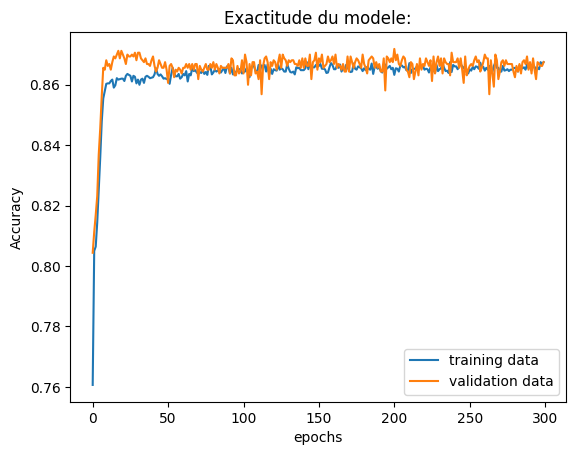

In [9]:
plt.plot(historique.history['accuracy'])
plt.plot(historique.history['val_accuracy'])
plt.title('Exactitude du modele:')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['training data','validation data'],loc='lower right')
plt.show()

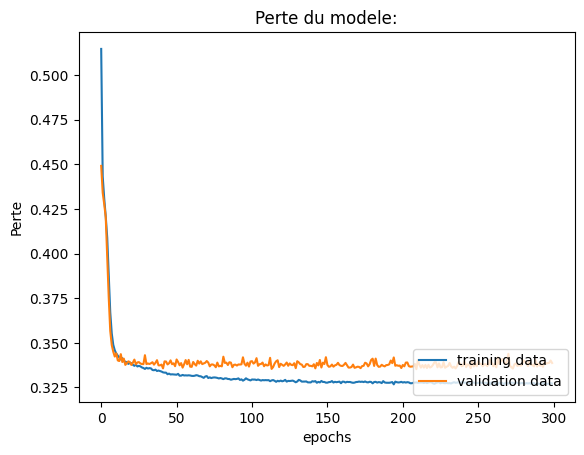

In [10]:
plt.plot(historique.history['loss'])
plt.plot(historique.history['val_loss'])
plt.title('Perte du modele:')
plt.ylabel('Perte')
plt.xlabel('epochs')
plt.legend(['training data','validation data'],loc='lower right')
plt.show()

In [11]:
print(historique.history['accuracy'][:6])

[0.7606250047683716, 0.8050000071525574, 0.8064062595367432, 0.8143749833106995, 0.824999988079071, 0.8359375]


##classification par XGBoost

In [16]:
x_train_1=x_train
y_train_1=y_train
x_test_1=x_test
y_test_1=y_test
param_grid = {
'max_depth':list(range(2,6,1)) ,
'learning_rate':[0.2,0.1,0.01,0.001],
'n_estimators':[50,100,300,400],
'reg_lambda':[0.5,0.1]
}
model = xgb.XGBClassifier()
grid_search = GridSearchCV(model,param_grid,cv=8,scoring='accuracy',n_jobs=-1)
grid_search.fit(x_train_1,y_train_1)
grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'reg_lambda': 0.5}

In [17]:
y_pred_1_train = grid_search.predict(x_train_1)
accuracy_gds_train = accuracy_score(y_train_1,y_pred_1_train)
accuracy_gds_train

0.871625

##classification par adaboost

In [29]:
param_grid ={
        'n_estimators':[100,1000],
        'estimator':[
                        DecisionTreeClassifier(max_depth=1),
                        DecisionTreeClassifier(max_depth=2),
                        LogisticRegression(solver='lbfgs',class_weight={0: class_weights[0], 1: class_weights[1]}),
                        LogisticRegression(solver='newton-cg',fit_intercept=True,penalty="l2",class_weight={0: class_weights[0], 1: class_weights[1]}),
                        LogisticRegression(solver='liblinear',class_weight={0: class_weights[0], 1: class_weights[1]}),
        ],
        
        'learning_rate':[0.1,0.01],
        'random_state':[42],
        'algorithm':['SAMME','SAMME.R']
    
    
    
    
}

In [30]:
grid_ada = GridSearchCV(AdaBoostClassifier(),param_grid,cv=5)

In [63]:
grid_ada.fit(x_train.to_numpy(),y_train.values.ravel())

C:\Users\karl\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\karl\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\karl\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 142, in fit
    self._validate_estimator()
  File "C:\Users\karl\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'estimator': [DecisionTreeClassifier(max_depth=1),
                                       DecisionTreeClassifier(max_depth=2),
                                       SVC(C=0.5, kernel='linear'),
                                       LogisticRegression()],
                         'learning_rate': [0.1, 0.01],
                         'n_estimators': [100, 1000], 'random_state': [42]})

In [64]:
best_ada = grid_ada.best_params_

In [65]:
best_ada

{'algorithm': 'SAMME.R',
 'estimator': DecisionTreeClassifier(max_depth=2),
 'learning_rate': 0.01,
 'n_estimators': 1000,
 'random_state': 42}

## classification avec random forrest

In [37]:
# Initialisation du classifieur
rfc = RandomForestClassifier()

# Définition des hyperparamètres à optimiser
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10,15],
    'min_samples_split': [5,10, 15, 20],
    'criterion':["gini","entropy","log_loss"],
    'max_features':["sqrt","log2"]
}

# Initialisation du GridSearchCV
grid_rfc = GridSearchCV(rfc, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit du GridSearchCV sur les données d'entraînement
grid_rfc.fit(x_train.to_numpy(), y_train.values.ravel())


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [5, 10, 15, 20],
                         'n_estimators': [100, 200, 500]})

In [ ]:
## benchmark des modeles testes

In [ ]:
def plot_roc_curves(models, X_train, y_train, X_test, y_test):
    
    #dans le cas ou on veut reentrainer les modeles pour la comparaison
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbes ROC pour plusieurs modèles')

    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='Modèle %d (AUC = %0.2f)' % (i+1, roc_auc))

    plt.legend(loc="lower right")
    plt.show()

C:\Users\karl\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\karl\AppData\Local\Temp\ipykernel_14472\171820014.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


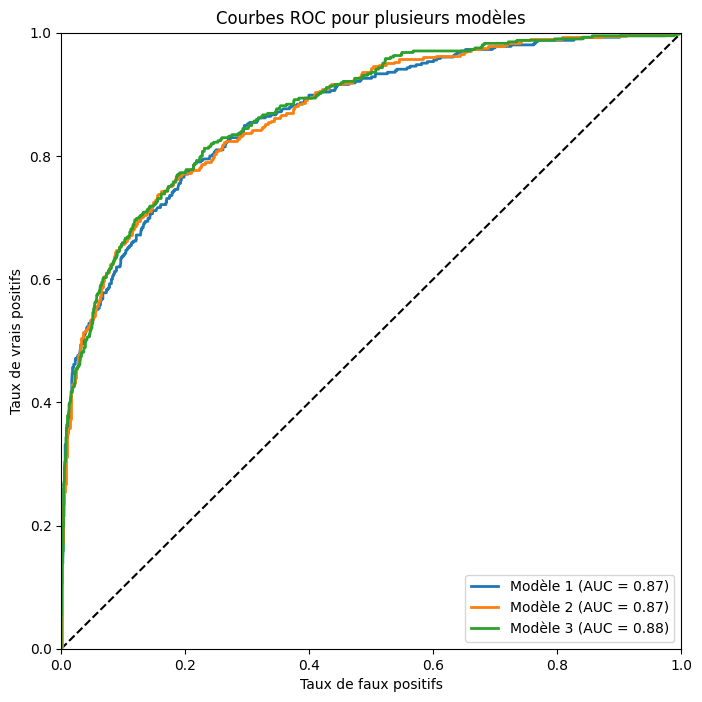

In [72]:
l_models= [grid_ada.best_estimator_,grid_rfc.best_estimator_,grid_search.best_estimator_]
plot_roc_curves(l_models, x_train, y_train, x_test, y_test)

In [59]:
## pour le model rna:
from keras.models import load_model
#classifier.load_weights(filepath=path_out+'\best_rna_model_churn.hdf5')

# Créer un nouveau modèle avec les mêmes couches et paramètres que le modèle original
best_model = Sequential()
best_model.add(Dense(units=6,kernel_initializer="glorot_uniform",activation='relu',input_dim=x_train.shape[1]))
best_model.add(Dense(units=6,kernel_initializer="glorot_uniform",activation='relu'))
best_model.add(Dense(units=1,kernel_initializer="glorot_uniform",activation='sigmoid'))
best_model.compile(optimizer="adam",loss='binary_crossentropy',metrics=["accuracy"])
# Charger les poids du meilleur modèle dans le nouveau modèle
best_model.fit(x_train, y_train,batch_size=10,epochs=30)


Epoch 1/30
800/800 [==============================] - 3s 2ms/step - loss: 0.4835 - accuracy: 0.7915
Epoch 2/30
800/800 [==============================] - 1s 2ms/step - loss: 0.4302 - accuracy: 0.7960
Epoch 3/30
800/800 [==============================] - 1s 2ms/step - loss: 0.4029 - accuracy: 0.8081
Epoch 4/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3834 - accuracy: 0.8397
Epoch 5/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3706 - accuracy: 0.8524
Epoch 6/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3622 - accuracy: 0.8590
Epoch 7/30
800/800 [==============================] - 2s 2ms/step - loss: 0.3564 - accuracy: 0.8600
Epoch 8/30
800/800 [==============================] - 2s 2ms/step - loss: 0.3526 - accuracy: 0.8616
Epoch 9/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3504 - accuracy: 0.8612
Epoch 10/30
800/800 [==============================] - 1s 2ms/step - loss: 0.3481 - accuracy: 0.8621

In [62]:
one_stat_result(best_model, x_train, y_train, x_test, y_test,b_seuil_label=True)

63/63 [==============================] - 0s 2ms/step
test_predictions:
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
Calculer l'erreur de validation:
0.134125
Calculer l'erreur de test:
0.1355
 overfitting_ratio = validation_error / test_error
0.9898523985239851
[[1513   82]
 [ 189  216]]
>> resultat de la classification:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1595
           1       0.72      0.53      0.61       405

    accuracy                           0.86      2000
   macro avg       0.81      0.74      0.77      2000
weighted avg       0.86      0.86      0.86      2000

Justesse de la Classification (accuracy) : 0.8645
Erreurs de Classification : 0.1355
Recall ou Sensitivity : 0.8890
taux de faux positive:
0.2751677852348993
False Positive Rate : 0.2752
Specificity : 0.7248


In [45]:
## pour le model rdf:
one_stat_result(grid_rfc, x_train, y_train, x_test, y_test)

C:\Users\karl\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\karl\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Calculer l'erreur de validation:
0.28651
Calculer l'erreur de test:
0.281635
 overfitting_ratio = validation_error / test_error
1.017309638361709
[[1533   62]
 [ 201  204]]
>> resultat de la classification:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1595
           1       0.77      0.50      0.61       405

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000

Justesse de la Classification (accuracy) : 0.8685
Erreurs de Classification : 0.1315
Recall ou Sensitivity : 0.8841
taux de faux positive:
0.23308270676691728
False Positive Rate : 0.2331
Specificity : 0.7669


In [47]:
##pour le model xgb:
one_stat_result(grid_search.best_estimator_, x_train, y_train, x_test, y_test)

Calculer l'erreur de validation:
0.276002
Calculer l'erreur de test:
0.2866925
 overfitting_ratio = validation_error / test_error
0.9627109184928103
[[1521   74]
 [ 196  209]]
>> resultat de la classification:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1595
           1       0.74      0.52      0.61       405

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.86      0.86      0.86      2000

Justesse de la Classification (accuracy) : 0.8650
Erreurs de Classification : 0.1350
Recall ou Sensitivity : 0.8858
taux de faux positive:
0.26148409893992935
False Positive Rate : 0.2615
Specificity : 0.7385


In [67]:
## pour le model ada:
one_stat_result(grid_ada.best_estimator_, x_train, y_train, x_test, y_test)

test_predictions:
[0 0 0 ... 0 0 0]
Calculer l'erreur de validation:
0.270378
Calculer l'erreur de test:
0.2795525
 overfitting_ratio = validation_error / test_error
0.9671814775399971
[[1538   57]
 [ 203  202]]
>> resultat de la classification:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1595
           1       0.78      0.50      0.61       405

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.77      2000
weighted avg       0.86      0.87      0.86      2000

Justesse de la Classification (accuracy) : 0.8700
Erreurs de Classification : 0.1300
Recall ou Sensitivity : 0.8834
taux de faux positive:
0.22007722007722008
False Positive Rate : 0.2201
Specificity : 0.7799
